In [1]:
from sklearn import linear_model
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# The Propublica/COMPAS Recidivism Data Set
## Loading the Data
Below, `allowed_factors` shows all of the data that the Propublica data set contains with 7214 people and 53 features. 

I have commented out the factors that are not relevant for predicting recidivism, not useful for debiasing, or not useful for measuring accuracy. 

If it is unclear what a variable is, I put a comment indicating what I think it is.

In [2]:
raw_data = pd.read_csv("./compas-scores-two-years.csv")
print('(#people, #features) =', raw_data.shape)

(#people, #features) = (7214, 53)


In [3]:
allowed_factors = [
    #'id',
    #'name',
    #'first',
    #'last',
    #'compas_screening_date',
    #'sex',
    #'dob',
    #'age_cat',
    'race',
    'decile_score', #COMPAS score
    'age',
    'juv_fel_count', 
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    #'days_b_screening_arrest', propublica uses this to filter data
    #  'c_jail_in', date
    #  'c_jail_out', date
    #  'c_case_number',
    #  'c_offense_date',
    #  'c_arrest_date',
    #  'c_days_from_compas',
    'c_charge_degree', #Misdemeanor or felony for original charge, need to make categorical
    #'c_charge_desc',
    'is_recid', 
    #'r_case_number',
    'r_charge_degree',#Misdemeanor or felony of re-offense, need to make categorical
    #  'r_days_from_arrest',
    #  'r_offense_date',
    #  'r_charge_desc',
    #  'r_jail_in',
    #  'r_jail_out',
    #'violent_recid', #all are NAN
    'is_violent_recid', #hey we can use this for groups!
    #  'vr_case_number',
    'vr_charge_degree', #maybe remove this from r_charge degree
    #  'vr_offense_date',
    #  'vr_charge_desc', #weird that vr_charge_desc and r_charge_desc do not overlap
    #  'type_of_assessment',
    #  'decile_score.1',#same as decile score?
    'score_text',#low, medium, high risk based on COMPAS
    #  'screening_date',
    #  'v_type_of_assessment',
    #  'v_decile_score',
    #  'v_score_text', #low, medium high
    #  'v_screening_date',
    #  'in_custody',
    #  'out_custody',
    #'priors_count.1', #not sure what the dif is from priors_count. it is the same
    #  'start',
    #  'end',
    # 'event', #no clue what this means?!?
    #'two_year_recid' # same as is_recid
] 

In [4]:
predictive_features = [ # comment or uncomment any features to use in logistic regression training
    'age',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    #'c_charge_degree' #<-- not included in COMPAS algorithm
    ]

protected_features = ['race']

Filter the data just as Propublica does [here](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb) and only include African Americans and Caucasians, leaving $\sim$ 5000 people.

In [5]:
filtered_data = raw_data.loc[(raw_data['is_recid'] != -1) & 
                             (raw_data['days_b_screening_arrest'] <=30) &
                             (raw_data['days_b_screening_arrest'] >=-30) &
                             (raw_data['c_charge_degree'] != 'O') &
                             (raw_data['score_text'] != 'N/A') &
                             (raw_data['race'].isin(['African-American', 'Caucasian']))
                            ]
final_data = filtered_data[allowed_factors]
# reset index skewed by removing rows
final_data = final_data.reset_index()
del final_data["index"]
print('the dimensions of final_data are', final_data.shape)
final_data[['r_charge_degree']] = final_data[['r_charge_degree']].fillna(0)

the dimensions of final_data are (5278, 13)


Change current charge and race into 0/1

In [6]:
def coding(col, code_dict):
    '''
    col: column of df to change encoding
    code_dict: {'key':value,...}
    '''
    col_coded = pd.Series(col, copy=True)
    for key, value in code_dict.items():
        col_coded.replace(key, value, inplace=True)
    return col_coded

In [7]:
# for c_charge_degree, change M(misdomeaner)/F(felony) to 0/1
final_data["c_charge_degree"] = coding(final_data["c_charge_degree"], {'M':0,'F':1})

# for race, change Caucasian/African-American to 0/1
final_data["race"] = coding(final_data["race"], {'Caucasian':0, 'African-American':1})

final_data.head(5)

,race,decile_score,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,r_charge_degree,is_violent_recid,vr_charge_degree,score_text
0,1,3,34,0,0,0,0,1,1,(F3),1,(F3),Low
1,1,4,24,0,0,1,4,1,1,(M1),0,NaN,Low
2,0,6,41,0,0,0,14,1,1,(F2),0,NaN,Medium
3,0,1,39,0,0,0,0,0,0,0,0,NaN,Low
4,0,4,27,0,0,0,0,1,0,0,0,NaN,Low


## Now we need to shuffle the data and split it into 3 pieces:
<ol>
  <li>A debiasing train set we use to debias the data.</li>
  <li>A training set to train logistic regression.</li>
  <li>A test set to measure false positive rates, false negative rates, etc.</li>
</ol>

In [8]:
from sklearn.model_selection import train_test_split
def split_data(df, debias_train_size, standard_training_set_percentage):
    '''
    Splits data into testing, training, and debias estimator sets
    
    Args:
        df: dataframe
        debias_train_size: at least 10 * number of feautes
        standard_training_set_percentage: percentage split for train/test of df\debias_train_df
        
    Returns: 
        debias_train_df
        train_df
        test_df
    '''
    debias_train_index = random.sample(range(df.shape[0]), debias_train_size)
    debias_train_df = df.loc[debias_train_index,:]
    
    df = df.drop(debias_train_index)
    
    train_df, test_df = train_test_split(df, train_size=standard_training_set_percentage, shuffle=True)
    
    test_df = test_df.reset_index()
    del test_df["index"]
    
    train_df = train_df.reset_index()
    del train_df["index"]
    
    debias_train_df = debias_train_df.reset_index()
    del debias_train_df["index"]
    
    return debias_train_df, train_df, test_df

## Debiasing Features

We assume that the data $Y = X A^T + Z B^T + E$, where $X$ is protected attributes like gender, $Z$ are unknown but are "discriminative" attributes and $E$ is an error term. 

We partition the rows of $Y$ into multiple "homogeneous groups": 
<ol>
  <li>Consider those who have been charged with a **non-violent** crime within 2 years. We split this set into multiple groups depending on whether or not someone has commmitted a $n$th degree felony or misdemeanor. </li>
  <li>Consider those who have been charged with a **violent** crime within 2 years. We split this set into multiple groups depending on whether or not someone has commmitted a $n$th degree felony or misdemeanor. </li>
  <li>Those who have **not** committed a crime after 2 years.</li>
</ol>

We assume that when the text of `vr_charge_degree` and `r_charge_degree` do not match for a person, it is due to one incident resulting in different violent and non-violent charges. In the case when someone recidivates and this incident results in a non-violent and violent charge, we only consider the violent charge.

To debias the data, we use least squares to estimate $A$.

In [9]:
# encode race as dummmy variables for OLS estimate
def race_dummy_encoding(df_race, white_black_ecoding):
    white = white_black_ecoding[0]
    black = white_black_ecoding[1]
    white_dummy_encoding = [1 if x == white else 0 for x in df_race]
    black_dummy_encoding = [1 if x == black else 0 for x in df_race]
    return pd.DataFrame({"white":white_dummy_encoding, "black":black_dummy_encoding})

In [10]:
def recid_no_recid_index(is_resid, group_elements):
    group_indices = []
    for i, element in enumerate (group_elements):
        group_indices.append(np.where(col == element))
        group_indices[i] = list(group_indices[i][0])
    
    return group_indices

def violent_nonviolent_norecid_index(is_violent_recid, is_recid):
    group_indices = [None]*3
    violent_index = np.where(is_violent_recid == 1)[0]
    group_indices[0] = violent_index

    is_recid_dropped = is_recid.drop(violent_index, inplace=False)
    
    group_indices[1] = is_recid_dropped[is_recid_dropped == 1].index
    
    group_indices[2] = is_recid_dropped[is_recid_dropped == 0].index
    
    return group_indices

def all_cat_index(vr_charge_degree, r_charge_degree): # <--current one in use

    group_dict = {}
    
    # ['(F3)', '(M1)', '(F2)', '(F1)', '(F6)', '(F7)', '(M2)']
    vr_charge = vr_charge_degree.dropna().unique()
    
    for charge in vr_charge:
        group_dict[charge] = np.where(vr_charge_degree == charge)[0]
        
    # don't double count those already indexed by a violent crime
    drop = np.concatenate(list(group_dict.values()))
    r_charge_degree_dropped = r_charge_degree.drop(drop, inplace=False)
    
    # ['(M1)', 0 (no recid), '(M2)', '(F2)', '(F3)', '(F6)', '(F1)', '(F7)', '(MO3)']
    r_charge = r_charge_degree.unique()

    for charge in r_charge:
        group_dict[(charge, 'nonV')] = r_charge_degree_dropped[r_charge_degree_dropped ==charge].index

    return list(group_dict.values())
    

In [11]:
def center_by_homogeneous_subgroups(group_indices, Y):
    '''
    Args:
        Y: dataframe to debias
        group_indices: array whose elements are list of indices for the homogeneous subgroups
    Returns:
        centered Y
    '''
    G = pd.DataFrame(columns=list(Y))
    for g in  group_indices:
        G = G.append(Y.loc[g] - Y.loc[g].mean(0)) 
    centered_Y = G.sort_index(0)
        
    return centered_Y

In [12]:
def estimate_A(centered_Y_train, X, fit_intercept):
    ols = linear_model.LinearRegression(fit_intercept)
    ols.fit(X, centered_Y_train)
    A_hat = ols.coef_
    b = ols.intercept_
    return A_hat, b

In [13]:
def biased_debiased_probs(data, debias_train_size, train_percentage_split):
    # split into testing/training/debias estimate sets
    debias_train_df, train_df, test_df = split_data(data, debias_train_size, train_percentage_split)

    # encode dummy race variables for debias training set
    X_dummy_encoding = race_dummy_encoding(debias_train_df[protected_features].race, [0,1])

    # Y for debias training
    Y = debias_train_df[predictive_features]

    # get group indices
    group_indices = all_cat_index(debias_train_df.vr_charge_degree, debias_train_df.r_charge_degree)
    # center by group indices
    centered_Y_train = center_by_homogeneous_subgroups(group_indices, Y)

    # get estimate of A
    A_hat, b = estimate_A(centered_Y_train, X_dummy_encoding, True)
    
    # ecode dummy race varialbes for training and testing set
    train_race_dummy_encoding = race_dummy_encoding(train_df.race, [0,1])
    test_race_dummy_encoding = race_dummy_encoding(test_df.race, [0,1])
    
    train = train_df[predictive_features]
    train_debiased = train - np.matmul(train_race_dummy_encoding.values,A_hat.T)-b.T

    test = test_df[predictive_features]
    test_debiased = test - np.matmul(test_race_dummy_encoding.values,A_hat.T)-b.T
    
    logit = linear_model.LogisticRegression()
    logit_debiased = linear_model.LogisticRegression()
    logit.fit(train, train_df.is_recid)
    logit_debiased.fit(train_debiased, train_df.is_recid)

    probs = list(logit.predict_proba(test)[:,1])
    probs_debiased = list(logit_debiased.predict_proba(test_debiased)[:,1])

    return probs, probs_debiased, test_df.race, test_df.decile_score, test_df.is_recid

In [14]:
def FPR(prediction, recid_label):
    '''
    false positive/(false positive + true negative)
    '''
    FP = sum([1 for x in range(len(prediction)) if prediction[x] == 1 and recid_label[x] ==0])
    TN = sum([1 for x in range(len(prediction)) if prediction[x] == 0 and recid_label[x] ==0])
    return FP/(FP+TN)

def FNR(prediction, recid_label):
    '''
    false negative/(false negative + true positive)
    '''
    FN = sum([1 for x in range(len(prediction)) if prediction[x] == 0 and recid_label[x] ==1])
    TP = sum([1 for x in range(len(prediction)) if prediction[x] == 1 and recid_label[x] ==1])
    return FN/(FN+TP)

def FPR_FNR_accuracy(recid_label, race, score, threshold=.5):
    white_index = np.where(race == 0)[0]
    black_index = np.where(race == 1)[0]
    
    prediction = np.array([1 if x >= threshold else 0 for x in score])
    
    pop_FPR = FPR(prediction, recid_label)
    pop_FNR = FNR(prediction, recid_label)
    
    white_FPR = FPR([prediction[i] for i in white_index], [recid_label[i] for i in white_index])
    white_FNR = FNR([prediction[i] for i in white_index], [recid_label[i] for i in white_index])
    
    black_FPR = FPR([prediction[i] for i in black_index], [recid_label[i] for i in black_index])
    black_FNR = FNR([prediction[i] for i in black_index], [recid_label[i] for i in black_index])
    
    accuracy = sum(prediction == recid_label)/len(recid_label)
    
    return [pop_FPR, pop_FNR, white_FPR, white_FNR, black_FPR, black_FNR], accuracy

## Logistic Regression as a proxy to COMPAS

We use logistic regression.

In [15]:
def get_logistic_threshold(scores, logistic_quantile=50):
    return np.percentile(scores, logistic_quantile, interpolation='midpoint')

In [16]:
def plot_prob_hist(probs, race):
    print('the avg is', np.mean(probs))
    print('the median is', np.median(probs))
    
    probabilities_AA = [probs[i] for i in np.where(race == 1)[0]]
    probabilities_white = [probs[i] for i in np.where(race == 0)[0]]
    
    plt.hist(probs, bins = 25)
    plt.title("Histogram of Probabilities of Recidivism from Logistic Regression on Test Set")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of people")
    plt.ylim((0,200))
    plt.show()

    print('Notice the difference in scale on the y-axis!')
    probabilities_AA = [probs[i] for i in np.where(race == 1)[0]]
    probabilities_white = [probs[i] for i in np.where(race == 0)[0]]
    
    ax1 = plt.subplot(121)
    ax1.set_ylim([0,140])
    
    plt.subplot(1,2,1)
    plt.hist(probabilities_AA, bins = 25)
    plt.title("Histogram of Probabilities \n of Recidivism for African-Americans \n under LR \n on Test Set")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")

    plt.subplot(1,2,2)
    plt.hist(probabilities_white, bins = 25)
    plt.title("Histogram of Probabilities \n of Recidivism for Caucasians \n under LR \n on Test Set")

    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of Caucasians")
    plt.tight_layout()
    plt.ylim((0,140))
    plt.show()    
    
    

## Quality of logistic regression trained on biased or debiased data & comparison to COMPAS

First we look at the distribution of probabilities assigned by logistic regression on the whole population and on both the white and black population separately for one split on both the biased and debiased data set.

the avg is 0.502016326369
the median is 0.488744393187


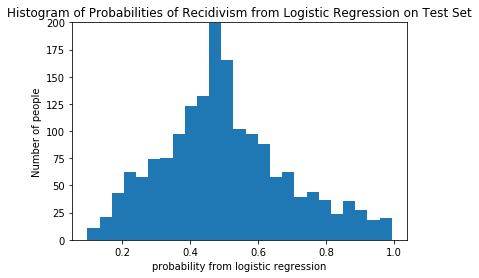

Notice the difference in scale on the y-axis!


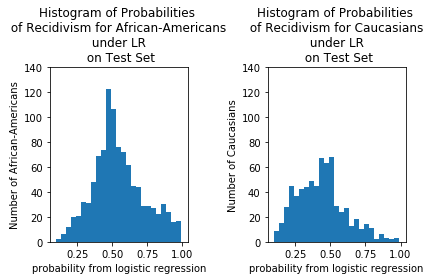

the avg is 0.502192203702
the median is 0.48236677331


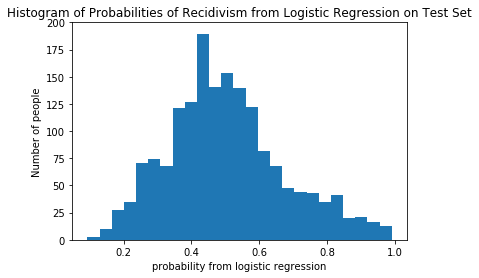

Notice the difference in scale on the y-axis!


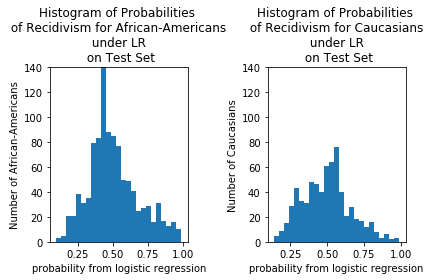

In [17]:
debias_train_size = 1000
train_percentage_split = .6

probs, probs_debiased, race, compas_decile_score, true_label = biased_debiased_probs(final_data, debias_train_size,  
                                                                                     train_percentage_split)
plot_prob_hist(probs, race)
plot_prob_hist(probs_debiased, race)

In [18]:
def logistic_histogram_before_after_AA(probs, probs_debiased, race):
    probabilities_AA = [probs[i] for i in np.where(race == 1)[0]]
    probabilities_AA_debias = [probs_debiased[i] for i in np.where(race == 1)[0]]
    
    #plt.subplot(1,2,1)
    plt.hist(probabilities_AA, bins = 25)
    plt.title("Histogram of Raw Logistic Regression \n Scores of African-Americans")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")

    #plt.subplot(1,2,2)
    plt.show()
    plt.hist(probabilities_AA_debias, bins = 25)
    plt.title("Histogram of Debiased Logistic Regression \n Scores of African-Americans")

    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")
    plt.tight_layout()
    plt.show()


    ax1 = plt.subplot(121)
    ax1.set_ylim([0,140])
    
    plt.subplot(1,2,1)
    plt.hist(probabilities_AA, bins = 25)
    plt.title("Raw")
    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")

    plt.subplot(1,2,2)
    #plt.show()
    plt.hist(probabilities_AA_debias, bins = 25)
    plt.title("Debiased")

    plt.xlabel("probability from logistic regression")
    plt.ylabel("Number of African-Americans")
    plt.tight_layout()
    plt.savefig('histo.pdf', format='pdf', dpi=1000)
    plt.ylim((0,140))
    plt.show()

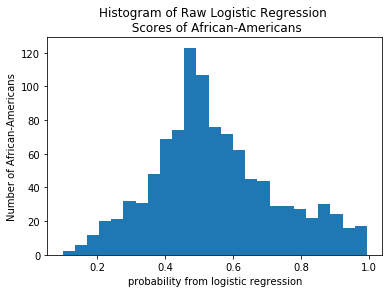

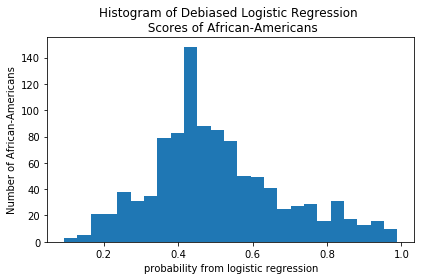

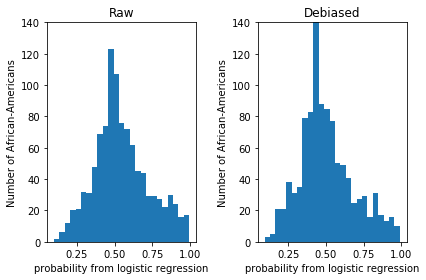

In [19]:
logistic_histogram_before_after_AA(probs, probs_debiased, race)

Now we look at ROC also under the same scenarios above.

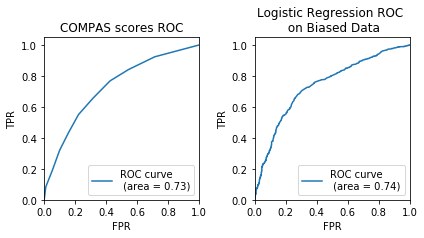

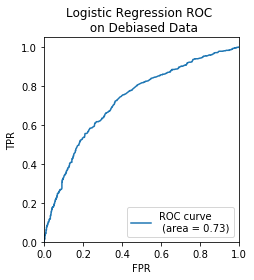

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

probs, probs_debiased, race, compas_decile_score, true_label = biased_debiased_probs(final_data, debias_train_size,  
                                                                                     train_percentage_split)

compasFpr, compasTpr, _ = roc_curve(true_label, compas_decile_score)
compasRocAuc = auc(compasFpr, compasTpr)

logisticFpr, logisticTpr, _ = roc_curve(true_label, probs)
logisticRocAuc = auc(logisticFpr, logisticTpr)

logisticFpr_debiased, logisticTpr_debiased, _ = roc_curve(true_label, probs_debiased)
logisticRocAuc_debiased = auc(logisticFpr_debiased, logisticTpr_debiased)

plt.figure()
plt.subplot(1,2,1)
plt.plot(compasFpr, compasTpr, label='ROC curve \n (area = %0.2f)' % compasRocAuc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('COMPAS scores ROC')
plt.legend(loc="lower right")
plt.gca().set_aspect('equal', adjustable='box')
#plt.show()

plt.subplot(1,2,2)
plt.plot(logisticFpr, logisticTpr, label='ROC curve \n (area = %0.2f)' % logisticRocAuc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC \n on Biased Data')
plt.legend(loc="lower right")
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

plt.figure()
plt.plot(logisticFpr_debiased, logisticTpr_debiased, label='ROC curve \n (area = %0.2f)' % logisticRocAuc_debiased)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Logistic Regression ROC \n on Debiased Data')
plt.legend(loc="lower right")
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [21]:
num_splits = 30
compas_score_threshold = 8 # 5 for medium and high, 8 for high
logistic_quantile = 50

biased_accuracy = np.zeros(num_splits)
debiased_accuracy = np.zeros(num_splits)
compas_accuracy = np.zeros(num_splits)

biased_logistic_regression_threshold = np.zeros(num_splits)
debiased_logistic_regression_threshold = np.zeros(num_splits)

# [pop_FPR, pop_FNR, white_FPR, white_FNR, black_FPR, black_FNR]
rates_biased = np.zeros((num_splits,6))
rates_debiased = np.zeros((num_splits,6))

for i in range(num_splits):

    probs, probs_debiased, race, compas_decile_score, recid_label = biased_debiased_probs(final_data, 1000, .6)
    
    risk_threshold_biased = get_logistic_threshold(probs, logistic_quantile)
    biased_logistic_regression_threshold[i] = risk_threshold_biased
    rates_biased[i,], biased_accuracy[i] = FPR_FNR_accuracy(recid_label, race, probs, risk_threshold_biased)
    
    risk_threshold_debiased = get_logistic_threshold(probs_debiased, logistic_quantile)
    debiased_logistic_regression_threshold[i] = risk_threshold_debiased
    rates_debiased[i,], debiased_accuracy[i] = FPR_FNR_accuracy(recid_label, 
                                                                race, 
                                                                probs_debiased, 
                                                                risk_threshold_debiased)
    
    compas_prediction = np.array([1 if x >= compas_score_threshold else 0 for x in compas_decile_score])
    compas_accuracy[i] = sum(compas_prediction == recid_label) / len(recid_label)
    
compas_FPR_FNR, _ = FPR_FNR_accuracy(recid_label, race, compas_decile_score, compas_score_threshold)

rate_debiased = np.mean(rates_debiased, axis=0)
rate_biased = np.mean(rates_biased, axis=0)
se_debiased = np.std(rates_debiased, axis=0)
se_biased = np.std(rates_biased, axis=0)

dfMatBiased = np.zeros((3,6))
dfMatBiased[:,2:6:2] = np.reshape(rate_biased,(3,2)).round(2)
dfMatBiased[:,3:7:2] = np.reshape(se_biased,(3,2)).round(2)
dfMatBiased[:, 0:2] = np.reshape(compas_FPR_FNR, (3,2)).round(2)
raw = dfMatBiased

labels = [np.array(['COMPAS', 'COMPAS', 'LR raw', 'LR raw', 'LR raw', 'LR raw']),
          np.array(['FPR', 'FNR', 'FPR', 'SE', 'FNR', 'SE'])]
raw_df = pd.DataFrame(raw, index=['Population', 'Caucasian', 'African-American'], columns=labels)

dfMatDebiased = np.zeros((3,6))
dfMatDebiased[:,2:6:2] = np.reshape(rate_debiased,(3,2)).round(2)
dfMatDebiased[:,3:7:2] = np.reshape(se_debiased,(3,2)).round(2)
dfMatDebiased[:, 0:2] = np.reshape(compas_FPR_FNR, (3,2)).round(2)
debiased = dfMatDebiased

labels = [np.array(['COMPAS', 'COMPAS', 'LR debiased', 'LR debiased', 'LR debiased', 'LR debiased']),
          np.array(['FPR', 'FNR', 'FPR', 'SE', 'FNR', 'SE'])]
debiased_df = pd.DataFrame(debiased, index=['Population', 'Caucasian', 'African-American'], columns=labels)

print(raw_df)
print('----------------')
print(debiased_df)
print('-----------')
print('Average biased logistic regression accuracy:', np.mean(biased_accuracy).round(2),
      'SE:', np.std(biased_accuracy).round(2))
print('Average debiased logistic regression accuracy:', np.mean(debiased_accuracy).round(2),
      'SE:', np.std(debiased_accuracy).round(2))
print('Average COMPAS accuracy:', np.mean(compas_accuracy).round(2), 'SE:', np.std(compas_accuracy).round(2))
print('-----------')
print('Average logistic regression biased threshold:', np.mean(biased_logistic_regression_threshold).round(2))
print('Average logistic regression debiased threshold:', np.mean(debiased_logistic_regression_threshold).round(2))

                 COMPAS       LR raw                  
                    FPR   FNR    FPR    SE   FNR    SE
Population         0.08  0.69   0.33  0.01  0.32  0.01
Caucasian          0.03  0.81   0.23  0.02  0.48  0.03
African-American   0.12  0.63   0.41  0.02  0.24  0.01
----------------
                 COMPAS       LR debiased                  
                    FPR   FNR         FPR    SE   FNR    SE
Population         0.08  0.69        0.35  0.01  0.34  0.01
Caucasian          0.03  0.81        0.44  0.03  0.31  0.03
African-American   0.12  0.63        0.27  0.02  0.36  0.02
-----------
Average biased logistic regression accuracy: 0.68 SE: 0.01
Average debiased logistic regression accuracy: 0.66 SE: 0.01
Average COMPAS accuracy: 0.61 SE: 0.01
-----------
Average logistic regression biased threshold: 0.49
Average logistic regression debiased threshold: 0.48


## Plot of difference of black/white FPR/FNR before and after debiasing

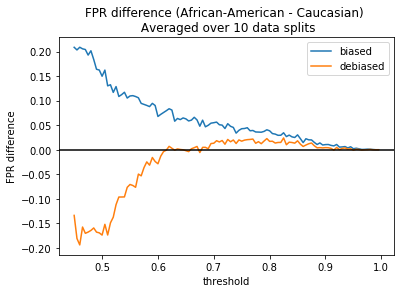

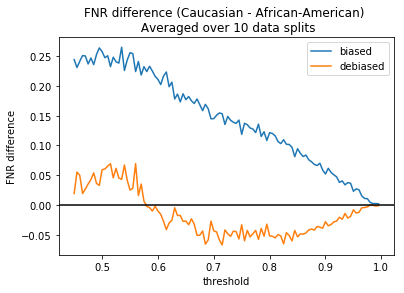

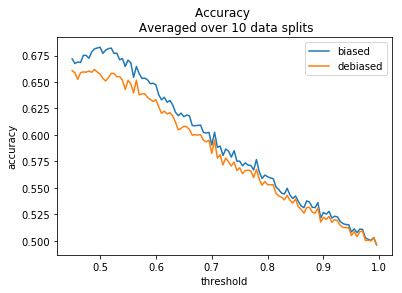

In [22]:
compas_score_threshold = 8 # 5 for medium and high, 8 for high
logistic_thresholds = [.45 + .005*i for i in range(110)]

biased_accuracy = np.zeros(len(logistic_thresholds))
debiased_accuracy = np.zeros(len(logistic_thresholds))
compas_accuracy = np.zeros(len(logistic_thresholds))

# [pop_FPR, pop_FNR, white_FPR, white_FNR, black_FPR, black_FNR]
rates_biased = np.zeros((len(logistic_thresholds),6))
rates_debiased = np.zeros((len(logistic_thresholds),6))

trials = 10

for _ in range(trials):
    for i in range(len(logistic_thresholds)):
        probs, probs_debiased, race, compas_decile_score, recid_label = biased_debiased_probs(final_data, 1000, .6)
        
        temp_rates_biased, temp_biased_accuracy = FPR_FNR_accuracy(recid_label, race, probs, logistic_thresholds[i]) 
        rates_biased[i,] = [x + y for x, y in zip(rates_biased[i,], temp_rates_biased)]
        biased_accuracy[i] += temp_biased_accuracy

        temp_rates_debiased, temp_debiased_accuracy = FPR_FNR_accuracy(recid_label, 
                                                                    race, 
                                                                    probs_debiased, 
                                                                    logistic_thresholds[i])
        rates_debiased[i,] = [x + y for x, y in zip(rates_debiased[i,], temp_rates_debiased)]
        debiased_accuracy[i] += temp_debiased_accuracy        

biased_accuracy = [i/trials for i in biased_accuracy]
debiased_accuracy = [i/trials for i in debiased_accuracy]

for i in range(len(logistic_thresholds)):
    rates_biased[i,] = [j/trials for j in rates_biased[i,]]  
    rates_debiased[i,] = [j/trials for j in rates_debiased[i,]] 
    
    
FPR_biased_dif = np.zeros(len(logistic_thresholds))
FNR_biased_dif = np.zeros(len(logistic_thresholds))
FPR_debiased_dif = np.zeros(len(logistic_thresholds))
FNR_debiased_dif = np.zeros(len(logistic_thresholds))
                           
for i in range(len(logistic_thresholds)):
    FPR_biased_dif[i] = rates_biased[i,4] - rates_biased[i,2]
    FNR_biased_dif[i] = rates_biased[i,3] - rates_biased[i,5]

    FPR_debiased_dif[i] = rates_debiased[i,4] - rates_debiased[i,2]
    FNR_debiased_dif[i] = rates_debiased[i,5] - rates_debiased[i,3]                                    

plt.figure()
plt.plot(logistic_thresholds, FPR_biased_dif)
plt.plot(logistic_thresholds, FPR_debiased_dif)
# plt.plot(FPR_biased_dif, logisticTpr_debiased, label='ROC curve \n (area = %0.2f)' % logisticRocAuc_debiased)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('threshold')
plt.ylabel('FPR difference')
plt.title('FPR difference (African-American - Caucasian) \n Averaged over %0.0f data splits' % trials)
plt.legend(['biased', 'debiased'], loc='upper right')
plt.axhline(y=0.0, color='black', linestyle='-')
# plt.legend(loc="lower right")
# plt.tight_layout()
plt.show()

plt.figure()

plt.plot(logistic_thresholds, FNR_biased_dif)
plt.plot(logistic_thresholds, FNR_debiased_dif)
# plt.plot(FPR_biased_dif, logisticTpr_debiased, label='ROC curve \n (area = %0.2f)' % logisticRocAuc_debiased)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('threshold')
plt.ylabel('FNR difference')
plt.title('FNR difference (Caucasian - African-American) \n Averaged over %0.0f data splits' % trials)
plt.legend(['biased', 'debiased'], loc='upper right')
plt.axhline(y=0.0, color='black', linestyle='-')
# plt.legend(loc="lower right")
# plt.tight_layout()
plt.show()

plt.figure()
plt.plot(logistic_thresholds, biased_accuracy)
plt.plot(logistic_thresholds, debiased_accuracy)
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.title('Accuracy \n Averaged over %0.0f data splits' % trials)
plt.legend(['biased', 'debiased'], loc='upper right')
# plt.legend(loc="lower right")
# plt.tight_layout()
plt.show()